# Window - 2019 December 24

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns

from src.dataset import OzeDataset
from src.Transformer import Transformer
from src.utils import visual_sample

In [2]:
# Training parameters
DATASET_PATH = 'datasets/dataset_large.npz'
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-4
EPOCHS = 20

# Testing parameters
TEST_DATASET_PATH = 'datasets/dataset_test.npz'

# Model parameters
K = 672 # Time window length
d_model = 48 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack
pe = None # Positional encoding
chunk_mode = 'window'

d_input = 37 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Training

### Load dataset

In [3]:
dataloader = DataLoader(OzeDataset(DATASET_PATH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS
                       )

### Load network

In [4]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, K, N, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)

temperature_loss_function = nn.MSELoss()
consumption_loss_function = nn.MSELoss()

### Train

[Epoch  20/20]: 100%|██████████| 7500/7500 [03:57<00:00, 31.56it/s, loss=0.000808]


Loss: 0.000808


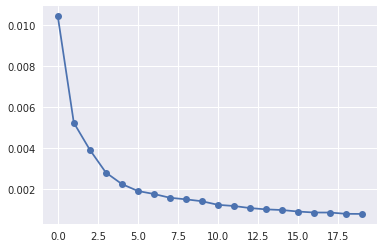

In [5]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            y = y.to(device)
            
            delta_Q = consumption_loss_function(netout[..., :-1], y[..., :-1])
            delta_T = temperature_loss_function(netout[..., -1], y[..., -1])
            
            loss = torch.log(1 + delta_T) + 0.3 * torch.log(1 + delta_Q)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
    hist_loss[idx_epoch] = running_loss/len(dataloader)
plt.plot(hist_loss, 'o-')
print(f"Loss: {float(hist_loss[-1]):5f}")

str_loss = str(hist_loss[-1]).split('.')[-1][:5]
torch.save(net, f"models/model_{str_loss}.pth")

## Validation

### Load dataset and network

In [6]:
datatestloader = DataLoader(OzeDataset(TEST_DATASET_PATH),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS
                           )

In [7]:
# net = torch.load('models/model_00247.pth', map_location=device)

### Plot results on a sample

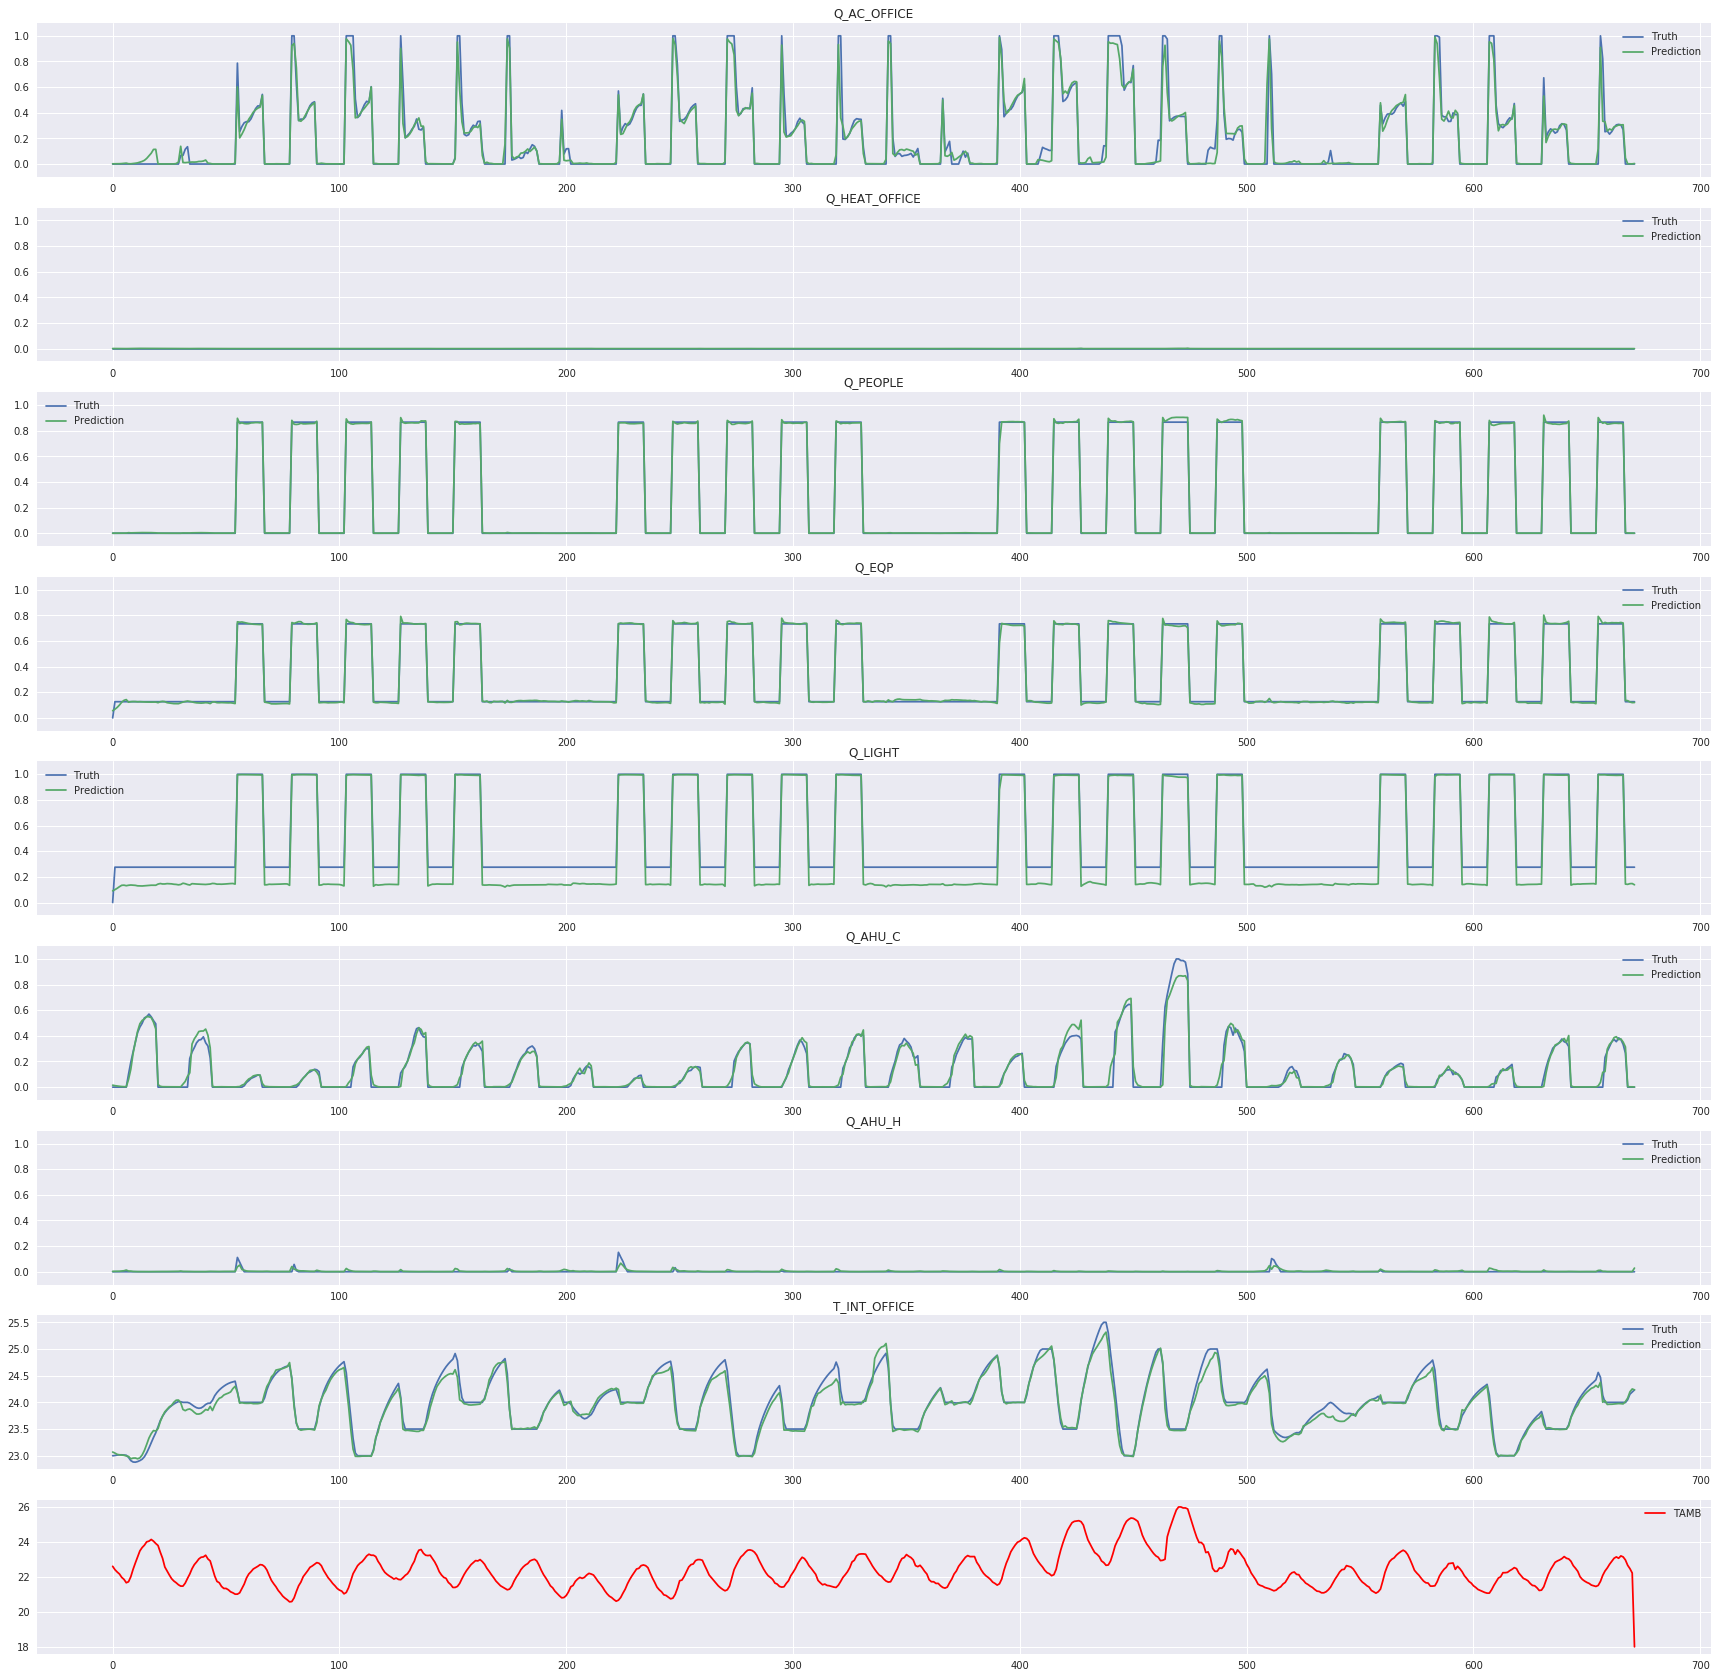

In [8]:
visual_sample(datatestloader, net, device)
plt.savefig("fig.jpg")

### Plot encoding attention map

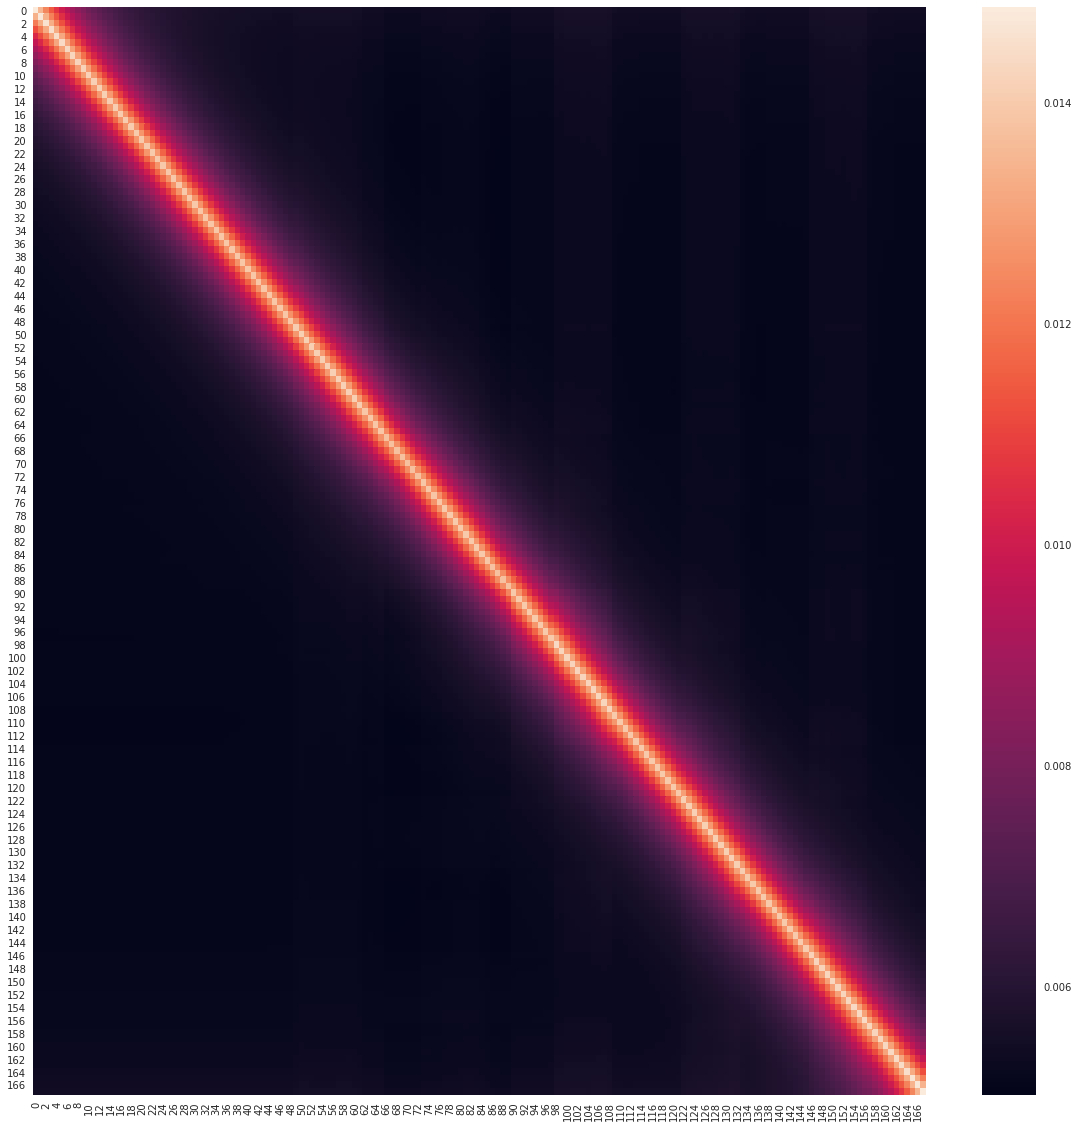

In [9]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu()

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(attn_map)
plt.savefig("attention_map.jpg")

### Evaluate on the test dataset

In [10]:
predictions = np.empty(shape=(len(datatestloader.dataset), K, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(datatestloader, total=len(datatestloader)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:06<00:00, 20.57it/s]


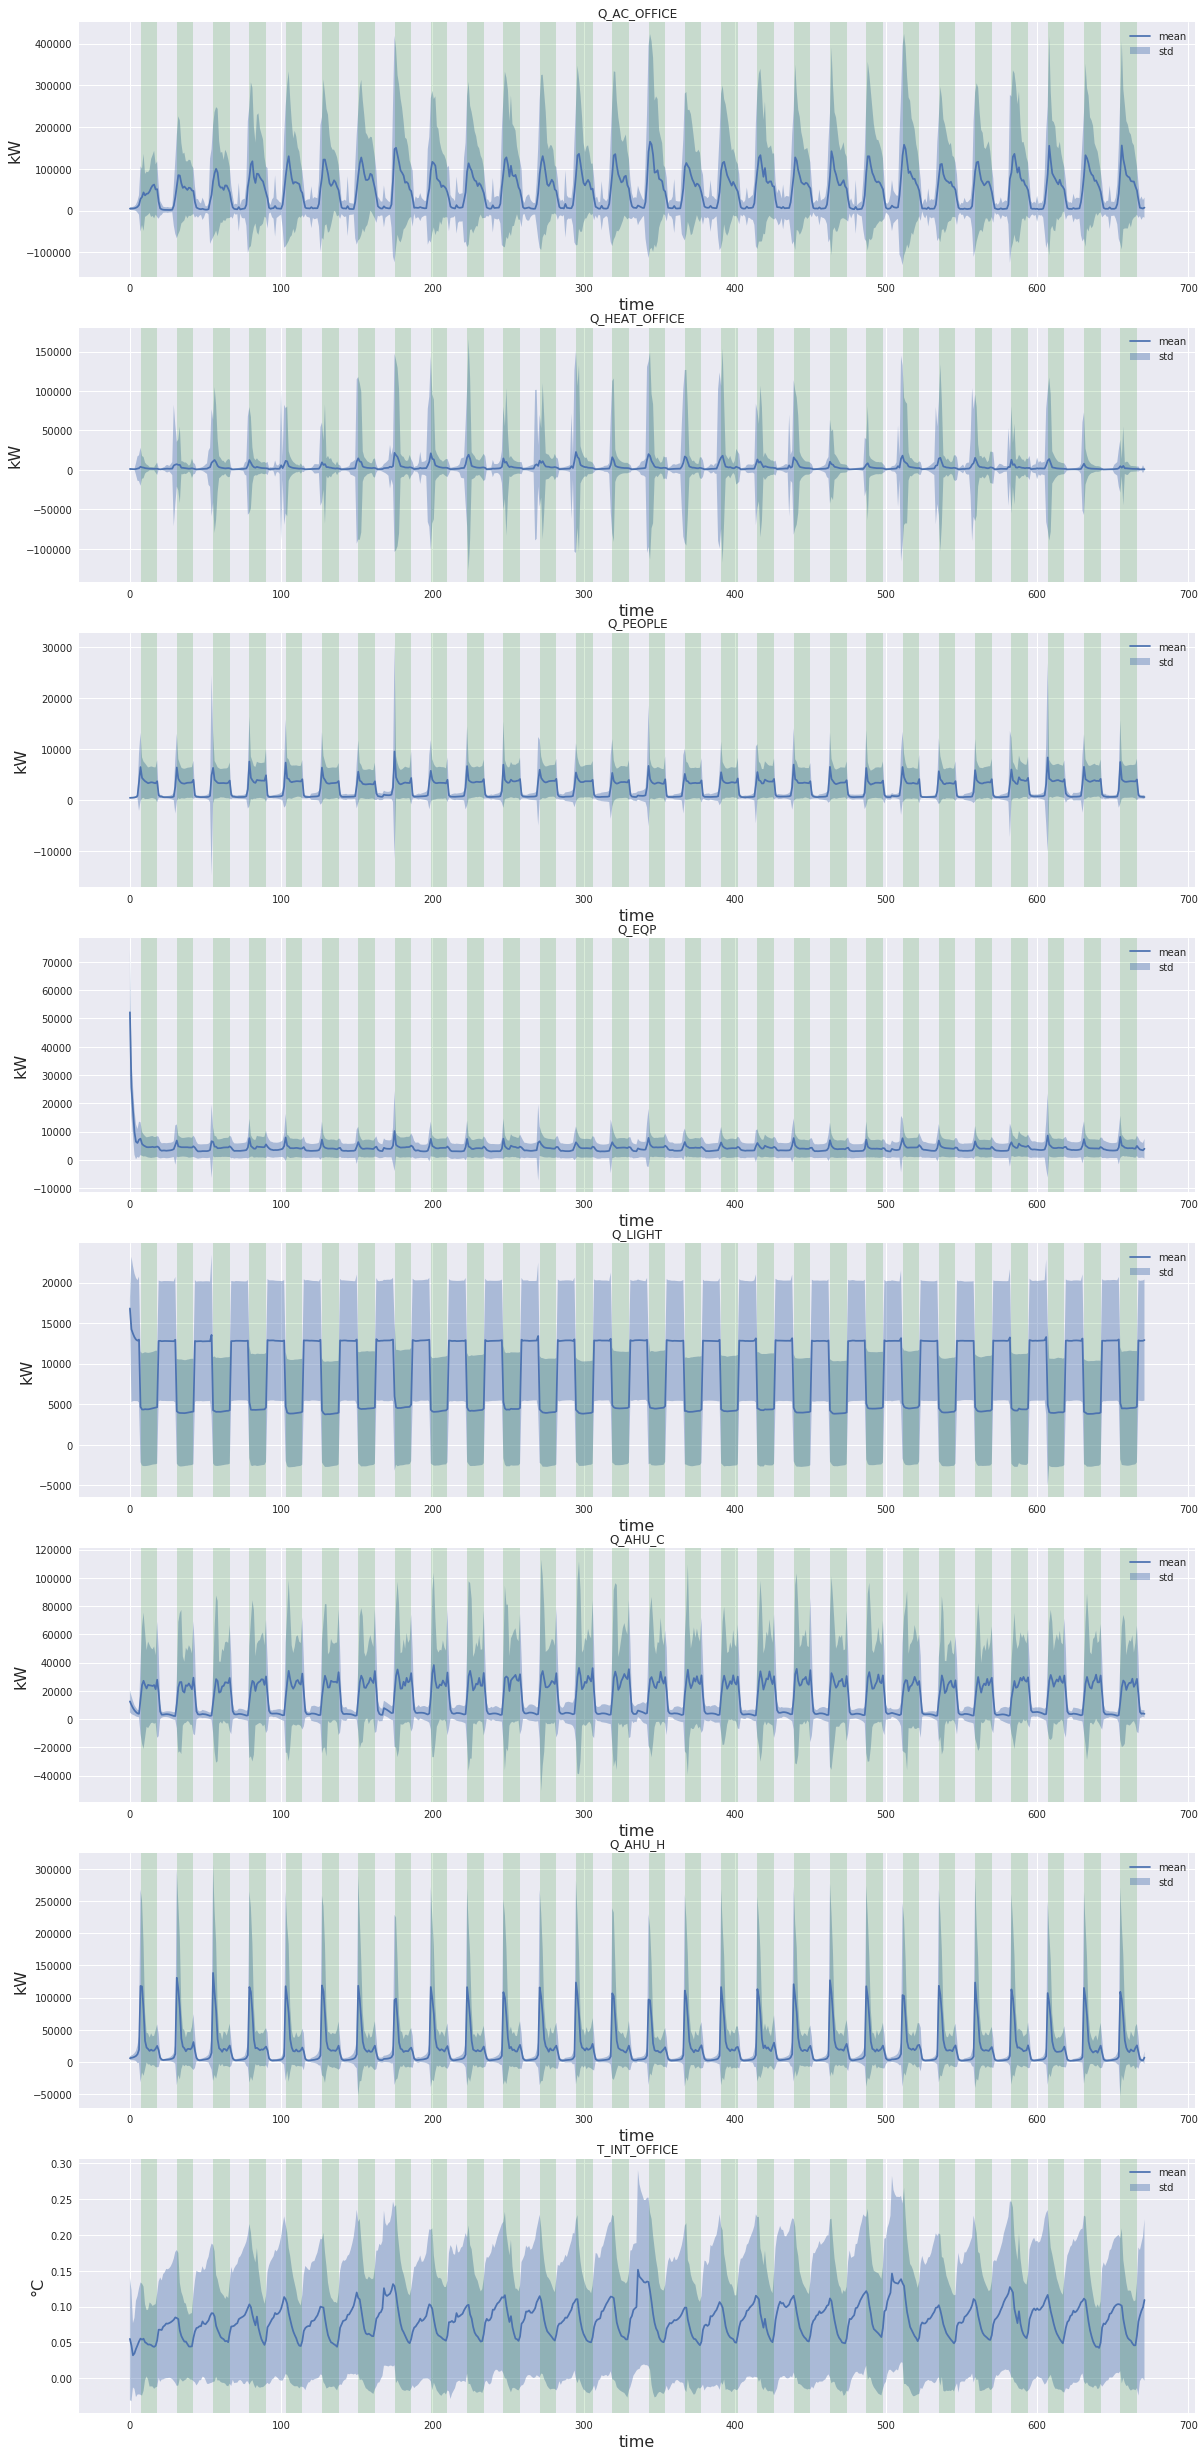

In [11]:
fig, axes = plt.subplots(8, 1)
fig.set_figwidth(20)
fig.set_figheight(40)
plt.subplots_adjust(bottom=0.05)

occupancy = (datatestloader.dataset._x.numpy()[..., datatestloader.dataset.labels["Z"].index("occupancy")].mean(axis=0)>0.5).astype(float)

for idx_label, (label, ax) in enumerate(zip(datatestloader.dataset.labels['X'], axes)):
    # Select output to plot
    y_true = datatestloader.dataset._y.numpy()[..., idx_label]
    y_pred = predictions[..., idx_label]
    
    # Rescale
    y_true = datatestloader.dataset.rescale(y_true, idx_label)
    y_pred = datatestloader.dataset.rescale(y_pred, idx_label)
    
    # Compute delta, mean and std
    delta = np.abs(y_true - y_pred)
    
    mean = delta.mean(axis=0)
    std = delta.std(axis=0)
    
    # Plot
    # Labels for consumption and temperature
    if label.startswith('Q_'):
        y_label_unit = 'kW'
    else:
        y_label_unit = '°C'
    
    # Occupancy
    occupancy_idxes = np.where(np.diff(occupancy) != 0)[0]
    for idx in range(0, len(occupancy_idxes), 2):
        ax.axvspan(occupancy_idxes[idx], occupancy_idxes[idx+1], facecolor='green', alpha=.15)
    
    # Std
    ax.fill_between(np.arange(mean.shape[0]), (mean - std), (mean + std), alpha=.4, label='std')
    
    # Mean
    ax.plot(mean, label='mean')
    
    # Title and labels
    ax.set_title(label)
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel(y_label_unit, fontsize=16)
    ax.legend()
    
plt.savefig('error_mean_std.jpg')